*PART 3: First step of 3*

***

# What This Part is About?

In this part we will create a Machine Learning model to classify loans into accepted/rejected.

# Data and Module Import

In [1]:
import pandas as pd
import numpy as np
import warnings
from utilities import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from category_encoders import OneHotEncoder, OrdinalEncoder, PolynomialEncoder, HelmertEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, fbeta_score, f1_score, roc_curve
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.utils import resample, class_weight
import optuna
import shap
import pickle

warnings.filterwarnings('ignore')

df = pd.read_csv('./prepared_data.csv', index_col=0)

df.head()

c:\Users\rokaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,loan_amnt,title,risk_score,dti,addr_state,emp_length,target
0,3600.0,Debt consolidation,679.0,5.91,PA,10+ years,1
1,24700.0,Business,719.0,16.06,SD,10+ years,1
2,35000.0,Debt consolidation,789.0,17.06,NJ,10+ years,1
3,10400.0,Major purchase,699.0,25.37,PA,3 years,1
4,11950.0,Debt consolidation,694.0,10.20,GA,4 years,1


***

# 4. Model Learning

## 4.1. Data Preparation

For this step, our target feature is `target`.

But before predicting it, we must sample down our dataset and split it.

In [2]:
X = df.drop(columns='target')
y = df['target']

len(X) == len(y)

True

In [3]:
X, y = resample(X, y, n_samples=len(X) // 100, random_state=42)
X.shape[0]

109853

**Data Split**

We are splitting the data into 3 parts:

1. Train - used to train models;
2. Validation - used to tune models;
3. Test - a model has only one shot at this dataset.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

**Determining Columns**

In [5]:
text_feature = 'title'
categorical_features = X.dtypes[df.dtypes != np.number].index.drop('title')
numerical_features = X.dtypes[df.dtypes == np.number].index

**Class Weights**

In [6]:
y_unique = np.unique(y_train.to_list())

class_weights = class_weight.compute_class_weight('balanced', classes=y_unique, y=y_train)

class_weights = {y_unique[i]: class_weights[i] for i in range(len(y_unique))}

scale_pos_weight = class_weights[1] / class_weights[0]

## 4.2. Base Model

Let's use vanilla LogisticRegression model for our base.

First, let's create a basic Pipeline.

In [7]:
col_transformer = ColumnTransformer([
    ('hash', HashingVectorizer(), text_feature),
    ('tfidf', TfidfVectorizer(), text_feature),
    ('encoder', OneHotEncoder(), categorical_features),
    ('scaler', StandardScaler(), numerical_features)
])

rfc_model = RandomForestClassifier(random_state=42, class_weight=class_weights)

pipe = make_pipeline(col_transformer, TruncatedSVD(), rfc_model)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

model_report(y_pred, y_test)

Accuracy:
	 0.8772927950480178 

Confusion matrix:
 [[16396  1293]
 [ 1403  2879]] 

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92     17689
           1       0.69      0.67      0.68      4282

    accuracy                           0.88     21971
   macro avg       0.81      0.80      0.80     21971
weighted avg       0.88      0.88      0.88     21971
 



## 4.3. Brute Forcing Models

For this task, I will be samplig down my dataset, because we have a lot of models to go through.

Additionally, I am going to split models into two parts, since some models don't need scaling.

*NOTE: Using TruncatedSVD for dimensionality reduction*

**Random Sampling**

In [8]:
scalers = [
    'passthrough',
    StandardScaler(),
    MinMaxScaler()
]

encoders = [
    OneHotEncoder(),
    OrdinalEncoder(),
    HelmertEncoder()
]

models_with_scaling = [
    LogisticRegression(class_weight=class_weights, random_state=42),
    KNeighborsClassifier()
]

models_without_scaling = [
    DecisionTreeClassifier(class_weight=class_weights, random_state=42),
    RandomForestClassifier(class_weight=class_weights, random_state=42),
    XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
    CatBoostClassifier(class_weights=class_weights, iterations=500, learning_rate=0.01, random_seed=42, silent=True)
]

In [9]:
models_with_scaling_df = brute_force_models(X_train, y_train, text_feature, categorical_features, numerical_features, scalers, encoders, models_with_scaling)

0 ['OneHotEncoder', 'passthrough', 'LogisticRegression', 0.5879282411695278, 0.5604006502101632, 0.24735207492302674, 0.3410127526185087]
1 ['OneHotEncoder', 'passthrough', 'KNeighborsClassifier', 0.852467767754624, 0.5845976840570868, 0.6182426217819749, 0.600833757941065]
2 ['OneHotEncoder', 'StandardScaler', 'LogisticRegression', 0.8436376805284315, 0.8842476568054437, 0.5555327299343568, 0.6823526229310757]
3 ['OneHotEncoder', 'StandardScaler', 'KNeighborsClassifier', 0.8767733159972224, 0.7044275304139824, 0.6659790636416201, 0.6845826356119933]
4 ['OneHotEncoder', 'MinMaxScaler', 'LogisticRegression', 0.9176768957570574, 0.9098098894744837, 0.7261009837198749, 0.8076260002848231]
5 ['OneHotEncoder', 'MinMaxScaler', 'KNeighborsClassifier', 0.9262035711177896, 0.8261706399604819, 0.7937263887154542, 0.8096102334046886]
6 ['OrdinalEncoder', 'passthrough', 'LogisticRegression', 0.5682513823100566, 0.583962950529652, 0.2408273904070776, 0.33964145964953124]
7 ['OrdinalEncoder', 'passt

In [10]:
models_without_scaling_df = brute_force_models(X_train, y_train, text_feature, categorical_features, numerical_features, ['passthrough'], encoders, models_without_scaling)

0 ['OneHotEncoder', 'passthrough', 'DecisionTreeClassifier', 0.8767125051846228, 0.6791813721298021, 0.6742017421724703, 0.6766664176561494]
1 ['OneHotEncoder', 'passthrough', 'RandomForestClassifier', 0.8776380649032222, 0.6360436485801702, 0.6942654973544723, 0.6638122534781487]
2 ['OneHotEncoder', 'passthrough', 'XGBClassifier', 0.8369316443906409, 0.9341742943611436, 0.5411075636941035, 0.685210348423071]
3 ['OneHotEncoder', 'passthrough', '<catboost.core.CatBoostClassifier object at 0x00000206CF696550>', 0.7556097502757335, 0.9233910042772955, 0.43284826755858513, 0.5893837860294945]
4 ['OrdinalEncoder', 'passthrough', 'DecisionTreeClassifier', 0.870355537934637, 0.6550557222706554, 0.6599360385854587, 0.657436407660027]
5 ['OrdinalEncoder', 'passthrough', 'RandomForestClassifier', 0.8738754203300843, 0.621584609650528, 0.6853984550121265, 0.6518013766986558]
6 ['OrdinalEncoder', 'passthrough', 'XGBClassifier', 0.8354447856109266, 0.9344940384637477, 0.5385293008884762, 0.68327449

In [11]:
models_df = pd.concat([models_with_scaling_df, models_without_scaling_df])
models_df.groupby('model').mean().sort_values(['f1_score', 'accuracy'], ascending=False)

,accuracy,recall,precision,f1_score
model,,,,
KNeighborsClassifier,0.892795,0.728391,0.709943,0.718498
XGBClassifier,0.836244,0.934920,0.539897,0.684458
DecisionTreeClassifier,0.874932,0.670873,0.670753,0.670777
RandomForestClassifier,0.876348,0.631384,0.691118,0.659793
<catboost.core.CatBoostClassifier object at 0x00000206CF696550>,0.755225,0.923311,0.432438,0.588984
LogisticRegression,0.733416,0.628533,0.442418,0.499967


Two best models for our problem are K-Neighbours classifier and XGBClassifier.

In [12]:
models_df[models_df['model'] == 'KNeighborsClassifier'].sort_values('f1_score', ascending=False)[:1]

,encoder,scaler,model,accuracy,recall,precision,f1_score
5,OneHotEncoder,MinMaxScaler,KNeighborsClassifier,0.926204,0.826171,0.793726,0.80961


K-Neighbours Classifier has 92% accuracy, 83% recall, 79% precision and 0.81 f1 score while using OneHotEncoder and MinMaxScaler.

In [13]:
models_df[models_df['model'] == 'XGBClassifier'].sort_values('f1_score', ascending=False)[:1]

,encoder,scaler,model,accuracy,recall,precision,f1_score
2,OneHotEncoder,passthrough,XGBClassifier,0.836932,0.934174,0.541108,0.68521


Best XGB Classifier uses OneHotEncoding and has an accuracy of 83%, recall of 0.93, precision of 0.54 and f1 score of 0.69.

## 4.4. K-Neighbours Classifier

In [14]:
encoder = OneHotEncoder()
scaler = MinMaxScaler()

knc_model = KNeighborsClassifier()

knc_column_transformer = ColumnTransformer([
    ('hash', HashingVectorizer(), text_feature),
    ('tfidf', TfidfVectorizer(), text_feature),
    ('cat', encoder, categorical_features),
    ('num', scaler, numerical_features)
])

knc_pipe = make_pipeline(knc_column_transformer, TruncatedSVD(), knc_model)

knc_pipe.fit(X_train, y_train)

y_pred = knc_pipe.predict(X_validate)

model_report(y_pred, y_validate)

Accuracy:
	 0.9257202676255063 

Confusion matrix:
 [[16939   773]
 [  859  3400]] 

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     17712
           1       0.81      0.80      0.81      4259

    accuracy                           0.93     21971
   macro avg       0.88      0.88      0.88     21971
weighted avg       0.93      0.93      0.93     21971
 



Base K-Neighbors Classsifier has an accuracy of 93% and f1 of 0.93.

### Model Tuning

In [15]:
def knc_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50, log=True)

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors
    )

    pipe = make_pipeline(knc_column_transformer, TruncatedSVD(), model)

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_validate)
    
    f1 = f1_score(y_pred, y_validate)
    
    return f1

In [16]:
knc_study = optuna.create_study(direction='maximize')

knc_study.optimize(knc_objective, n_trials=20, show_progress_bar=True)

[I 2023-09-03 08:00:20,988] A new study created in memory with name: no-name-a3fc3be0-22ee-4c49-adbf-076e3d3c0be9
  0%|          | 0/20 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.736131:   5%|▌         | 1/20 [00:02<00:41,  2.21s/it]

[I 2023-09-03 08:00:23,196] Trial 0 finished with value: 0.7361312108055957 and parameters: {'n_neighbors': 1}. Best is trial 0 with value: 0.7361312108055957.


Best trial: 1. Best value: 0.784431:  10%|█         | 2/20 [00:04<00:39,  2.22s/it]

[I 2023-09-03 08:00:25,422] Trial 1 finished with value: 0.7844311377245509 and parameters: {'n_neighbors': 3}. Best is trial 1 with value: 0.7844311377245509.


Best trial: 2. Best value: 0.80455:  15%|█▌        | 3/20 [00:06<00:37,  2.22s/it] 

[I 2023-09-03 08:00:27,653] Trial 2 finished with value: 0.8045504054217597 and parameters: {'n_neighbors': 8}. Best is trial 2 with value: 0.8045504054217597.


Best trial: 3. Best value: 0.820405:  20%|██        | 4/20 [00:08<00:35,  2.23s/it]

[I 2023-09-03 08:00:29,896] Trial 3 finished with value: 0.8204048204048204 and parameters: {'n_neighbors': 13}. Best is trial 3 with value: 0.8204048204048204.


Best trial: 3. Best value: 0.820405:  25%|██▌       | 5/20 [00:11<00:33,  2.22s/it]

[I 2023-09-03 08:00:32,086] Trial 4 finished with value: 0.7618200305033046 and parameters: {'n_neighbors': 4}. Best is trial 3 with value: 0.8204048204048204.


Best trial: 3. Best value: 0.820405:  30%|███       | 6/20 [00:13<00:30,  2.20s/it]

[I 2023-09-03 08:00:34,267] Trial 5 finished with value: 0.8105061165747183 and parameters: {'n_neighbors': 10}. Best is trial 3 with value: 0.8204048204048204.


Best trial: 3. Best value: 0.820405:  35%|███▌      | 7/20 [00:15<00:28,  2.19s/it]

[I 2023-09-03 08:00:36,413] Trial 6 finished with value: 0.7361312108055957 and parameters: {'n_neighbors': 1}. Best is trial 3 with value: 0.8204048204048204.


Best trial: 7. Best value: 0.821599:  40%|████      | 8/20 [00:17<00:26,  2.19s/it]

[I 2023-09-03 08:00:38,613] Trial 7 finished with value: 0.8215989759106249 and parameters: {'n_neighbors': 19}. Best is trial 7 with value: 0.8215989759106249.


Best trial: 7. Best value: 0.821599:  45%|████▌     | 9/20 [00:19<00:23,  2.18s/it]

[I 2023-09-03 08:00:40,775] Trial 8 finished with value: 0.7842432950191571 and parameters: {'n_neighbors': 3}. Best is trial 7 with value: 0.8215989759106249.


Best trial: 7. Best value: 0.821599:  50%|█████     | 10/20 [00:21<00:21,  2.18s/it]

[I 2023-09-03 08:00:42,947] Trial 9 finished with value: 0.8105061165747183 and parameters: {'n_neighbors': 10}. Best is trial 7 with value: 0.8215989759106249.


Best trial: 10. Best value: 0.821896:  55%|█████▌    | 11/20 [00:24<00:19,  2.20s/it]

[I 2023-09-03 08:00:45,212] Trial 10 finished with value: 0.8218956139335726 and parameters: {'n_neighbors': 46}. Best is trial 10 with value: 0.8218956139335726.


Best trial: 11. Best value: 0.823243:  60%|██████    | 12/20 [00:26<00:17,  2.22s/it]

[I 2023-09-03 08:00:47,471] Trial 11 finished with value: 0.8232428670842032 and parameters: {'n_neighbors': 38}. Best is trial 11 with value: 0.8232428670842032.


Best trial: 12. Best value: 0.825207:  65%|██████▌   | 13/20 [00:28<00:15,  2.24s/it]

[I 2023-09-03 08:00:49,746] Trial 12 finished with value: 0.8252069917203312 and parameters: {'n_neighbors': 49}. Best is trial 12 with value: 0.8252069917203312.


Best trial: 13. Best value: 0.8254:  70%|███████   | 14/20 [00:31<00:13,  2.24s/it]  

[I 2023-09-03 08:00:52,001] Trial 13 finished with value: 0.825400484038262 and parameters: {'n_neighbors': 41}. Best is trial 13 with value: 0.825400484038262.


Best trial: 13. Best value: 0.8254:  75%|███████▌  | 15/20 [00:33<00:11,  2.24s/it]

[I 2023-09-03 08:00:54,224] Trial 14 finished with value: 0.8237339205006374 and parameters: {'n_neighbors': 27}. Best is trial 13 with value: 0.825400484038262.


Best trial: 13. Best value: 0.8254:  80%|████████  | 16/20 [00:35<00:09,  2.26s/it]

[I 2023-09-03 08:00:56,526] Trial 15 finished with value: 0.8252069917203312 and parameters: {'n_neighbors': 49}. Best is trial 13 with value: 0.825400484038262.


Best trial: 13. Best value: 0.8254:  85%|████████▌ | 17/20 [00:37<00:06,  2.24s/it]

[I 2023-09-03 08:00:58,738] Trial 16 finished with value: 0.8208728208728209 and parameters: {'n_neighbors': 24}. Best is trial 13 with value: 0.825400484038262.


Best trial: 13. Best value: 0.8254:  90%|█████████ | 18/20 [00:39<00:04,  2.24s/it]

[I 2023-09-03 08:01:00,964] Trial 17 finished with value: 0.8216909620991254 and parameters: {'n_neighbors': 28}. Best is trial 13 with value: 0.825400484038262.


Best trial: 13. Best value: 0.8254:  95%|█████████▌| 19/20 [00:42<00:02,  2.22s/it]

[I 2023-09-03 08:01:03,157] Trial 18 finished with value: 0.8161339780634508 and parameters: {'n_neighbors': 18}. Best is trial 13 with value: 0.825400484038262.


Best trial: 13. Best value: 0.8254: 100%|██████████| 20/20 [00:44<00:00,  2.22s/it]

[I 2023-09-03 08:01:05,441] Trial 19 finished with value: 0.8234342500577768 and parameters: {'n_neighbors': 48}. Best is trial 13 with value: 0.825400484038262.


Best params for k-Neighbors Classifier are 31 `n_neighbors`.

In [17]:
final_knc_model = KNeighborsClassifier(**knc_study.best_params)

final_knc_pipe = make_pipeline(knc_column_transformer, TruncatedSVD(), final_knc_model)

final_knc_pipe.fit(X_train, y_train)

y_pred = final_knc_pipe.predict(X_validate)

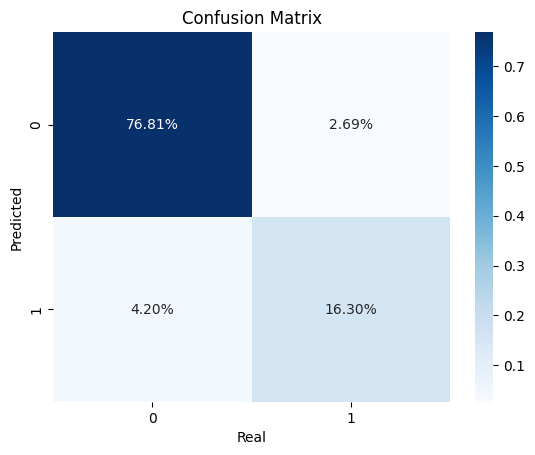

In [18]:
plot_confusion_matrix(y_pred, y_validate)

In [19]:
model_report(y_pred, y_validate)

Accuracy:
	 0.9310454690273542 

Confusion matrix:
 [[16875   592]
 [  923  3581]] 

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     17467
           1       0.86      0.80      0.83      4504

    accuracy                           0.93     21971
   macro avg       0.90      0.88      0.89     21971
weighted avg       0.93      0.93      0.93     21971
 



K-Neighbours tuned model has 93% accuracy and 0.93 f1 score.

## 4.5. XGBoost Classifier

In [20]:
encoder = OneHotEncoder()

xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

xgb_column_transformer = ColumnTransformer([
    ('hash', HashingVectorizer(), text_feature),
    ('tfidf', TfidfVectorizer(), text_feature),
    ('cat', encoder, categorical_features)
])

xgb_pipe = make_pipeline(xgb_column_transformer, TruncatedSVD(), xgb_model)

xgb_pipe.fit(X_train, y_train)

y_pred = xgb_pipe.predict(X_validate)

model_report(y_pred, y_validate)

Accuracy:
	 0.9258568112511948 

Confusion matrix:
 [[16616   447]
 [ 1182  3726]] 

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     17063
           1       0.89      0.76      0.82      4908

    accuracy                           0.93     21971
   macro avg       0.91      0.87      0.89     21971
weighted avg       0.92      0.93      0.92     21971
 



Base K-Neighbors Classsifier has an accuracy of 93% and f1 of 0.92.

It is very similar to K-Neighbors Classifier.

### Model Tuning

In [21]:
def xgb_objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 15)
    subsample = trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05)
    n_estimators = trial.suggest_int('n_estimators', 1000, 10000, 100)
    eta = trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01)
    reg_alpha = trial.suggest_int('reg_alpha', 1, 50)
    reg_lambda = trial.suggest_int('reg_lambda', 5, 100)
    min_child_weight = trial.suggest_int('min_child_weight', 2, 20)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
   
    model = XGBClassifier(
        random_state=42,
        max_depth=max_depth,
        subsample=subsample,
        n_estimators=n_estimators,
        eta=eta,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        scale_pos_weight=scale_pos_weight
    )  

    pipe = make_pipeline(xgb_column_transformer, TruncatedSVD(), model)

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_validate)
    
    f1 = f1_score(y_pred, y_validate)
    
    return f1

In [22]:
xgb_study = optuna.create_study(direction='maximize')

xgb_study.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

[I 2023-09-03 08:01:10,464] A new study created in memory with name: no-name-b81aaa9c-37d0-43e2-b74f-c0bbe92b24fa
Best trial: 0. Best value: 0.816658:   5%|▌         | 1/20 [00:13<04:16, 13.50s/it]

[I 2023-09-03 08:01:23,967] Trial 0 finished with value: 0.8166576527852893 and parameters: {'max_depth': 2, 'subsample': 0.85, 'n_estimators': 3800, 'eta': 0.06999999999999999, 'reg_alpha': 2, 'reg_lambda': 12, 'min_child_weight': 5, 'colsample_bytree': 0.9926734198687243}. Best is trial 0 with value: 0.8166576527852893.


Best trial: 0. Best value: 0.816658:  10%|█         | 2/20 [00:20<02:51,  9.51s/it]

[I 2023-09-03 08:01:30,673] Trial 1 finished with value: 0.8148867313915857 and parameters: {'max_depth': 4, 'subsample': 1.0, 'n_estimators': 1300, 'eta': 0.04, 'reg_alpha': 3, 'reg_lambda': 58, 'min_child_weight': 7, 'colsample_bytree': 0.2766178599496114}. Best is trial 0 with value: 0.8166576527852893.


Best trial: 0. Best value: 0.816658:  15%|█▌        | 3/20 [00:51<05:31, 19.52s/it]

[I 2023-09-03 08:02:02,120] Trial 2 finished with value: 0.8139459808457977 and parameters: {'max_depth': 14, 'subsample': 0.85, 'n_estimators': 6100, 'eta': 0.060000000000000005, 'reg_alpha': 41, 'reg_lambda': 13, 'min_child_weight': 9, 'colsample_bytree': 0.14188434790146015}. Best is trial 0 with value: 0.8166576527852893.


Best trial: 0. Best value: 0.816658:  20%|██        | 4/20 [01:19<06:04, 22.80s/it]

[I 2023-09-03 08:02:29,939] Trial 3 finished with value: 0.8138733304610082 and parameters: {'max_depth': 5, 'subsample': 0.85, 'n_estimators': 5300, 'eta': 0.05, 'reg_alpha': 30, 'reg_lambda': 15, 'min_child_weight': 14, 'colsample_bytree': 0.6109631862342295}. Best is trial 0 with value: 0.8166576527852893.


Best trial: 0. Best value: 0.816658:  25%|██▌       | 5/20 [02:05<07:48, 31.23s/it]

[I 2023-09-03 08:03:16,114] Trial 4 finished with value: 0.8138658628485306 and parameters: {'max_depth': 14, 'subsample': 0.95, 'n_estimators': 8500, 'eta': 0.060000000000000005, 'reg_alpha': 23, 'reg_lambda': 75, 'min_child_weight': 15, 'colsample_bytree': 0.3965862988475498}. Best is trial 0 with value: 0.8166576527852893.


Best trial: 5. Best value: 0.818251:  30%|███       | 6/20 [02:17<05:44, 24.61s/it]

[I 2023-09-03 08:03:27,882] Trial 5 finished with value: 0.8182509505703421 and parameters: {'max_depth': 5, 'subsample': 0.65, 'n_estimators': 1700, 'eta': 0.09999999999999999, 'reg_alpha': 2, 'reg_lambda': 12, 'min_child_weight': 3, 'colsample_bytree': 0.35964979350927373}. Best is trial 5 with value: 0.8182509505703421.


Best trial: 5. Best value: 0.818251:  35%|███▌      | 7/20 [02:47<05:44, 26.46s/it]

[I 2023-09-03 08:03:58,162] Trial 6 finished with value: 0.8140486964016376 and parameters: {'max_depth': 3, 'subsample': 0.9, 'n_estimators': 8400, 'eta': 0.09, 'reg_alpha': 49, 'reg_lambda': 96, 'min_child_weight': 19, 'colsample_bytree': 0.6430654767982869}. Best is trial 5 with value: 0.8182509505703421.


Best trial: 5. Best value: 0.818251:  40%|████      | 8/20 [03:12<05:09, 25.79s/it]

[I 2023-09-03 08:04:22,497] Trial 7 finished with value: 0.8181325235874634 and parameters: {'max_depth': 8, 'subsample': 0.65, 'n_estimators': 2600, 'eta': 0.05, 'reg_alpha': 10, 'reg_lambda': 23, 'min_child_weight': 20, 'colsample_bytree': 0.759109477508577}. Best is trial 5 with value: 0.8182509505703421.


Best trial: 5. Best value: 0.818251:  45%|████▌     | 9/20 [03:34<04:33, 24.88s/it]

[I 2023-09-03 08:04:45,372] Trial 8 finished with value: 0.8149186159318744 and parameters: {'max_depth': 2, 'subsample': 0.85, 'n_estimators': 6700, 'eta': 0.06999999999999999, 'reg_alpha': 9, 'reg_lambda': 52, 'min_child_weight': 8, 'colsample_bytree': 0.8110910742837051}. Best is trial 5 with value: 0.8182509505703421.


Best trial: 5. Best value: 0.818251:  50%|█████     | 10/20 [04:00<04:10, 25.09s/it]

[I 2023-09-03 08:05:10,941] Trial 9 finished with value: 0.8134063809216887 and parameters: {'max_depth': 3, 'subsample': 0.7, 'n_estimators': 5500, 'eta': 0.060000000000000005, 'reg_alpha': 41, 'reg_lambda': 76, 'min_child_weight': 18, 'colsample_bytree': 0.18991441224117783}. Best is trial 5 with value: 0.8182509505703421.


Best trial: 5. Best value: 0.818251:  55%|█████▌    | 11/20 [04:16<03:20, 22.28s/it]

[I 2023-09-03 08:05:26,834] Trial 10 finished with value: 0.8133476856835306 and parameters: {'max_depth': 8, 'subsample': 0.6, 'n_estimators': 1800, 'eta': 0.01, 'reg_alpha': 22, 'reg_lambda': 36, 'min_child_weight': 2, 'colsample_bytree': 0.42330407969286177}. Best is trial 5 with value: 0.8182509505703421.


Best trial: 11. Best value: 0.818478:  60%|██████    | 12/20 [04:41<03:05, 23.15s/it]

[I 2023-09-03 08:05:51,986] Trial 11 finished with value: 0.8184775536759923 and parameters: {'max_depth': 8, 'subsample': 0.7, 'n_estimators': 2800, 'eta': 0.09999999999999999, 'reg_alpha': 14, 'reg_lambda': 27, 'min_child_weight': 12, 'colsample_bytree': 0.5045827694794793}. Best is trial 11 with value: 0.8184775536759923.


Best trial: 11. Best value: 0.818478:  65%|██████▌   | 13/20 [05:12<02:59, 25.64s/it]

[I 2023-09-03 08:06:23,339] Trial 12 finished with value: 0.8182113821138213 and parameters: {'max_depth': 11, 'subsample': 0.75, 'n_estimators': 3400, 'eta': 0.09999999999999999, 'reg_alpha': 14, 'reg_lambda': 31, 'min_child_weight': 12, 'colsample_bytree': 0.4555883313526101}. Best is trial 11 with value: 0.8184775536759923.


Best trial: 11. Best value: 0.818478:  70%|███████   | 14/20 [05:21<02:02, 20.48s/it]

[I 2023-09-03 08:06:31,899] Trial 13 finished with value: 0.815278377211912 and parameters: {'max_depth': 6, 'subsample': 0.7, 'n_estimators': 1000, 'eta': 0.09999999999999999, 'reg_alpha': 16, 'reg_lambda': 41, 'min_child_weight': 2, 'colsample_bytree': 0.31814905056170506}. Best is trial 11 with value: 0.8184775536759923.


Best trial: 14. Best value: 0.818987:  75%|███████▌  | 15/20 [06:03<02:15, 27.03s/it]

[I 2023-09-03 08:07:14,127] Trial 14 finished with value: 0.8189872033249481 and parameters: {'max_depth': 10, 'subsample': 0.6, 'n_estimators': 4000, 'eta': 0.08, 'reg_alpha': 7, 'reg_lambda': 26, 'min_child_weight': 11, 'colsample_bytree': 0.5238233574463753}. Best is trial 14 with value: 0.8189872033249481.


Best trial: 14. Best value: 0.818987:  80%|████████  | 16/20 [06:31<01:48, 27.23s/it]

[I 2023-09-03 08:07:41,821] Trial 15 finished with value: 0.8134536857941113 and parameters: {'max_depth': 11, 'subsample': 0.6, 'n_estimators': 4200, 'eta': 0.08, 'reg_alpha': 30, 'reg_lambda': 49, 'min_child_weight': 11, 'colsample_bytree': 0.5202862836352683}. Best is trial 14 with value: 0.8189872033249481.


Best trial: 14. Best value: 0.818987:  85%|████████▌ | 17/20 [07:08<01:30, 30.25s/it]

[I 2023-09-03 08:08:19,104] Trial 16 finished with value: 0.8181226967266422 and parameters: {'max_depth': 11, 'subsample': 0.75, 'n_estimators': 4700, 'eta': 0.08, 'reg_alpha': 16, 'reg_lambda': 26, 'min_child_weight': 15, 'colsample_bytree': 0.5333402149305341}. Best is trial 14 with value: 0.8189872033249481.


Best trial: 14. Best value: 0.818987:  90%|█████████ | 18/20 [07:36<00:58, 29.44s/it]

[I 2023-09-03 08:08:46,633] Trial 17 finished with value: 0.8185874415061487 and parameters: {'max_depth': 9, 'subsample': 0.65, 'n_estimators': 2900, 'eta': 0.09, 'reg_alpha': 9, 'reg_lambda': 42, 'min_child_weight': 12, 'colsample_bytree': 0.4720327194525733}. Best is trial 14 with value: 0.8189872033249481.


Best trial: 18. Best value: 0.819766:  95%|█████████▌| 19/20 [08:46<00:41, 41.76s/it]

[I 2023-09-03 08:09:57,102] Trial 18 finished with value: 0.8197655308425551 and parameters: {'max_depth': 10, 'subsample': 0.6, 'n_estimators': 7400, 'eta': 0.08, 'reg_alpha': 7, 'reg_lambda': 64, 'min_child_weight': 10, 'colsample_bytree': 0.24240496060688765}. Best is trial 18 with value: 0.8197655308425551.


Best trial: 18. Best value: 0.819766: 100%|██████████| 20/20 [10:00<00:00, 30.01s/it]

[I 2023-09-03 08:11:10,566] Trial 19 finished with value: 0.8191014902643317 and parameters: {'max_depth': 12, 'subsample': 0.6, 'n_estimators': 7000, 'eta': 0.02, 'reg_alpha': 6, 'reg_lambda': 66, 'min_child_weight': 10, 'colsample_bytree': 0.27320588537688834}. Best is trial 18 with value: 0.8197655308425551.


In [23]:
final_xgb_model = XGBClassifier(**xgb_study.best_params)

final_xgb_pipe = make_pipeline(xgb_column_transformer, TruncatedSVD(), final_knc_model)

final_xgb_pipe.fit(X_train, y_train)

y_pred = final_xgb_pipe.predict(X_validate)

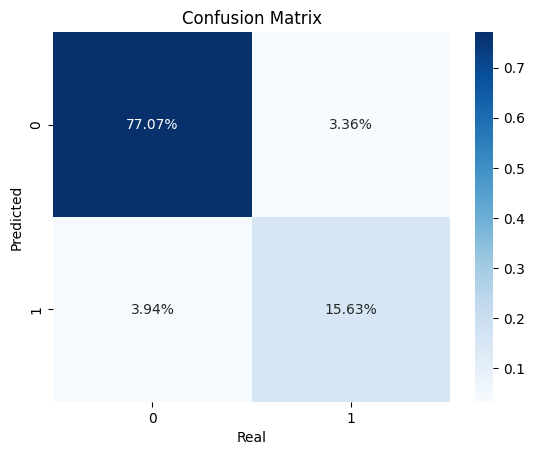

In [24]:
plot_confusion_matrix(y_pred, y_validate)

In [25]:
model_report(y_pred, y_validate)

Accuracy:
	 0.926949160256702 

Confusion matrix:
 [[16932   739]
 [  866  3434]] 

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     17671
           1       0.82      0.80      0.81      4300

    accuracy                           0.93     21971
   macro avg       0.89      0.88      0.88     21971
weighted avg       0.93      0.93      0.93     21971
 



After tuning, we have a model with 93% accuracy and 0.93 f1 score.

## 4.6. Final Model

### K-Neighbors versus XGBoost

Let's see how both models compare against test dataset.

**K-Neighbors**

In [26]:
y_pred = final_knc_pipe.predict(X_test)

model_report(y_pred, y_test)

Accuracy:
	 0.9171635337490328 

Confusion matrix:
 [[16547   568]
 [ 1252  3604]] 

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     17115
           1       0.86      0.74      0.80      4856

    accuracy                           0.92     21971
   macro avg       0.90      0.85      0.87     21971
weighted avg       0.92      0.92      0.91     21971
 



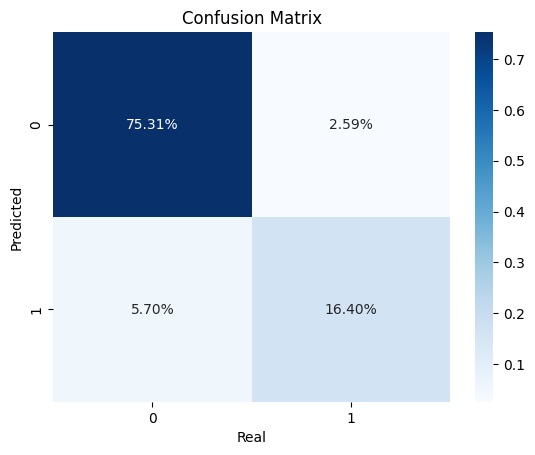

In [27]:
plot_confusion_matrix(y_pred, y_test)

**XGBoost**

In [28]:
y_pred = final_xgb_pipe.predict(X_test)

model_report(y_pred, y_test)

Accuracy:
	 0.9257202676255063 

Confusion matrix:
 [[16872   705]
 [  927  3467]] 

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     17577
           1       0.83      0.79      0.81      4394

    accuracy                           0.93     21971
   macro avg       0.89      0.87      0.88     21971
weighted avg       0.92      0.93      0.92     21971
 



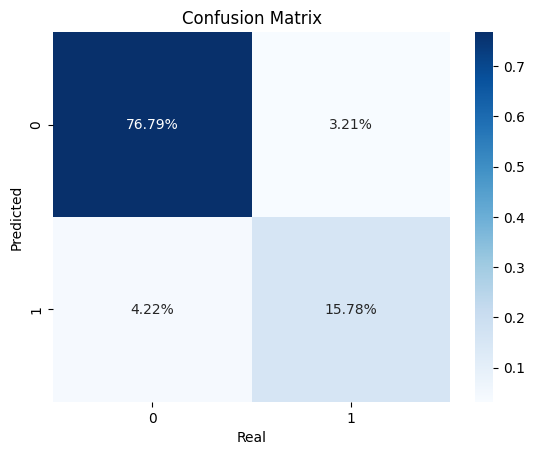

In [29]:
plot_confusion_matrix(y_pred, y_test)

Comparing these two models, XGBoost has better accuracy of 93% compared to 92% and f1 score of 0.93 against 0.91.

Meaning XGBoost will be our main model.

In [30]:
final_model = final_xgb_pipe

### ROC Curve

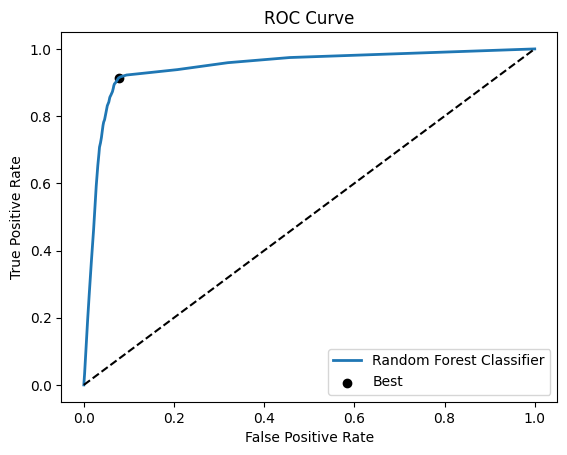

In [31]:
y_pred = final_model.predict_proba(X_test)
y_pred = y_pred[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plot_roc_curve(fpr, tpr, 'Random Forest Classifier')

We can see that the elbow is quite close to top left corner and area under the curve is big, meaning high AUC score.

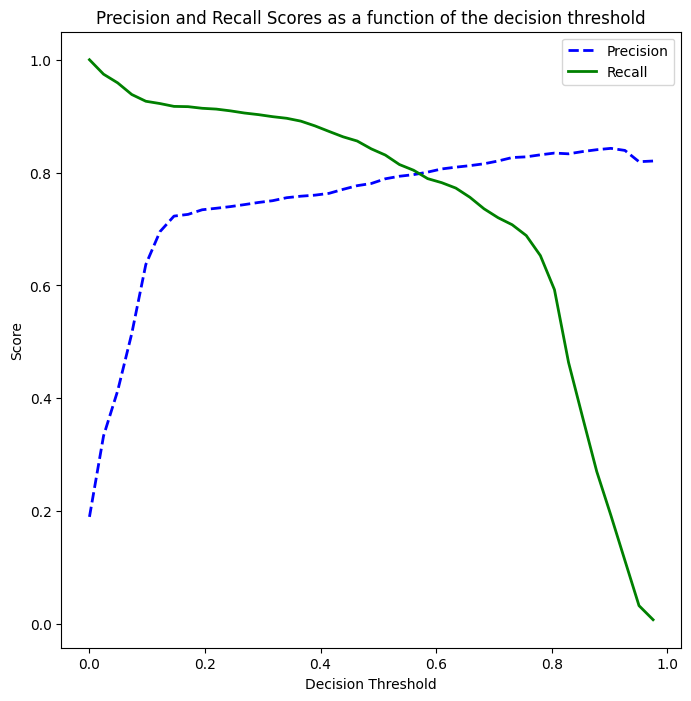

In [32]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred, pos_label=1)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

This grapgh shows Precision and Recall at each threshold. 

We can see that they collide at around 0.56.

### Saving the Model

In [33]:
pickle.dump(final_model, open('./model/app/model.pkl', 'wb'))

***

# End of Part 3

We have tried a bunch of models and found that K-Neighbors Classifier and Random Forest Classifier do the best job at predicting whether a loan is good or bad.

However, neither of those model were very good.

Random Forest model is more superion that K-Neighbors, but not by much.

Let's see how other model will be.

In another part we will try to create some models for predicting `grade`, `sub_grade` and `int_rate`.